In [3]:
import codecs
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, make_scorer
import time
import numpy as np
from skopt import gp_minimize
import matplotlib.pyplot as plt
from random import uniform
from skopt.acquisition import gaussian_ei

# Collect data

In [4]:
X = []
y = []
with codecs.open("machine.data", 'r', 'utf-8') as infile:
    for line in infile:
        tokens = line.split(',')
        X.append([float(x) for x in tokens[:5]])
        y.append(float(tokens[6]))
slice = int(round(len(X)*0.8))
X_train = X[:slice]
X_test = X[slice:]
y_train = y[:slice]
y_test = y[slice:]

# Apply Linear Regression LASSO (Manually)

In [5]:
def f(alphavalue):
    regr = linear_model.Lasso(alpha=alphavalue)
    regr.fit(X_train, y_train)
    y_pred = [i for i in regr.predict(X_test)]
    return mean_squared_error(y_test, y_pred)
print("loss of the model:{}".format(f(2.0)))

loss of the model:18498.541155206593


# Apply gridsearch

In [6]:
worst_case = float("inf")
mse_gs_scores = []
t0 = time.time()
for g in [(i+1)*0.001 for i in range(8000)]:
    mse = f(g)
    mse_gs_scores.append([g,mse])
    # save if best
    if mse < worst_case:
        worst_case = mse
        best_grid = g
t1 = time.time()
print("Time taken by gridsearch: {} seconds".format(round((t1 - t0),2)))
print("Mimima of MSE : {}".format(worst_case))
print("Best hyperparameter Value : {}".format(best_grid))

Time taken by gridsearch: 3.78 seconds
Mimima of MSE : 18497.325935295183
Best hyperparameter Value : 2.803


# Graphical Representation

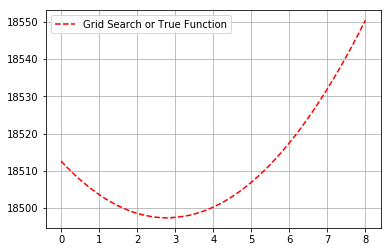

In [7]:
plt.plot([i[0] for i in mse_gs_scores], [i[1] for i in mse_gs_scores], "r--", label="Grid Search or True Function")
plt.legend()
plt.grid()
plt.show()

# Apply Random Search 

In [14]:
worst_case = float("inf")
mse_rs_scores = []
t0 = time.time()
for _ in range(1000):
    g = uniform(0, 8)
    mse = f(g)
    mse_rs_scores.append([g, mse])
    # save if best
    if mse < worst_case:
        worst_case = mse
        best_random = g
t1 = time.time()
print("Time taken by Random search: {} seconds".format(round((t1 - t0),2)))
print("Mimima of MSE : {}".format(worst_case))
print("Best hyperparameter Value : {}".format(best_grid))

Time taken by Random search: 0.46 seconds
Mimima of MSE : 18497.325946033998
Best hyperparameter Value : 2.803


# Graphical Representation

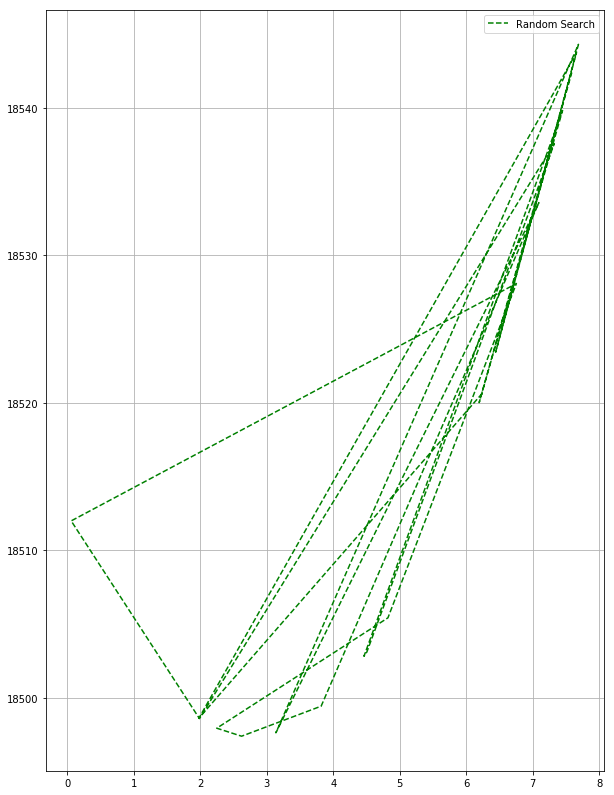

In [15]:
plt.plot([i[0] for i in mse_rs_scores][:20], [i[1] for i in mse_rs_scores][:20], "g--", label="Random Search")
plt.legend()
plt.grid()
plt.show()

# Apply Bayesian Optimization 

In [16]:

x = np.array([(i+1)*0.001 for i in range(8000)])
fx = [f(x_i) for x_i in x]
t4 = time.time()
res = gp_minimize(f,  # the function to minimize
                  [(0.001, 8.0)],  # the bounds on each dimension of x
                  acq_func="EI",  # the acquisition function
                  n_calls=15,  # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  random_state=123)
t5 = time.time()
print("Time taken by BO: {} seconds".format(round((t5 - t4),2)))
print("Mimima of MSE : {}".format(res['fun']))
print("Best hyperparameter Value : {}".format(res['x']))

Time taken by BO: 2.13 seconds
Mimima of MSE : 18497.325938709713
Best hyperparameter Value : [2.8020788166876063]


# Graphical Representation

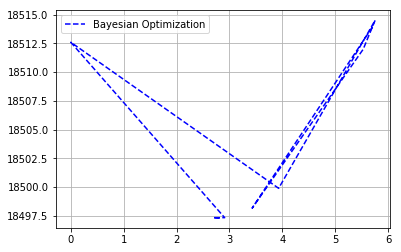

In [11]:
plt.plot(res.x_iters, res.func_vals, "b--", label="Bayesian Optimization")
plt.legend()
plt.grid()
plt.show()

# Combined Representation

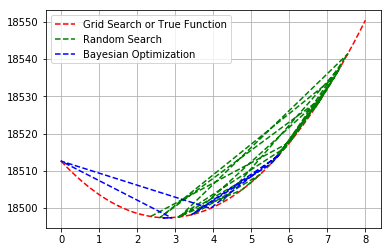

In [12]:
plt.plot([i[0] for i in mse_gs_scores], [i[1] for i in mse_gs_scores], "r--", label="Grid Search or True Function")
plt.plot([i[0] for i in mse_rs_scores][:20], [i[1] for i in mse_rs_scores][:20], "g--", label="Random Search")
plt.plot(res.x_iters, res.func_vals, "b--", label="Bayesian Optimization")
plt.legend()
plt.grid()
plt.show()

# Behaviour of Bayesian Optimization

/Users/piaggarwal/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/piaggarwal/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/piaggarwal/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/piaggarwal/miniconda3/lib/python3.6/site-packages/skopt/learning/gaussian_process/gpr.py:330: UserWarning: P

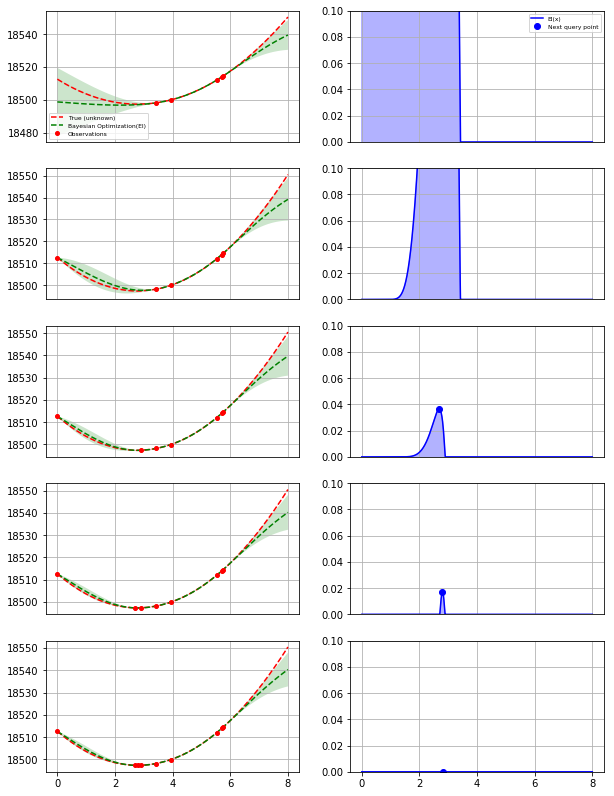

In [13]:
noise_level = 0.1
plt.rcParams["figure.figsize"] = (10, 14)

x = np.linspace(0.001, 8.0, 8000).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())
fx = np.array([f(x_i) for x_i in x])

# Plot the 5 iterations following the 5 random points
for n_iter in range(5):
    gp = res.models[n_iter]
    curr_x_iters = res.x_iters[:5 + n_iter]
    curr_func_vals = res.func_vals[:5 + n_iter]

    # Plot true function.
    plt.subplot(5, 2, 2 * n_iter + 1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label="Bayesian Optimization(EI)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")

    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off',
                        top='off', labelbottom='off')

        # Plot EI(x)
    plt.subplot(5, 2, 2 * n_iter + 2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')

    next_x = res.x_iters[5 + n_iter]
    next_acq = gaussian_ei(res.space.transform([next_x]), gp, y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")

    # Adjust plot layout
    plt.ylim(0, 0.1)
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off',
                        top='off', labelbottom='off')

plt.show()